In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import uuid
from math import sqrt

In [2]:
INIT_PREDATORS = 500        #Początkowa liczba drapieżników
INIT_PREYS = 1500            #Początkowa liczba ofiar
X_MIN = 0
X_MAX = 2
Y_MIN = 0
Y_MAX = 2
global SAFE_DISTANCE
SAFE_DISTANCE = 0.1         #odległość potrzebna do ataku drapieżnika
global PREDATOR_EFFECTIVENESS
PREDATOR_EFFECTIVENESS = 50 #liczba z zakresu od 0-100 określająca szansę na śmierć ofiary w starciu z drapieżnikiem
global MAX_VITALITY
MAX_VITALITY = 50           #wytrzymałość drapieżników (ile rund jest w stanie wytrzymać bez jedzenia)
ITERATIONS = 1000            #liczba iteracji / kroków w błądzeniu losowym, którą symulujemy
global STEP_SIZE
STEP_SIZE = 0.2
global PREY_MULTIPLICATION_RATIO
PREY_MULTIPLICATION_RATIO = 0.05  #o ile % zwiększa się liczebność ofiar w każdej rundzie (liczba z zakresu 0-1)

In [3]:
class SurfaceBoundaries:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

In [4]:
global surfaceBoundaries
surfaceBoundaries = SurfaceBoundaries(X_MIN, X_MAX, Y_MIN, Y_MAX)

In [5]:
class Position:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        
    def __str__(self):
        return ("Position(" + str(self.x) + ", " + str(self.y) + ")")
    
    def isWithinBoundaries(self) -> bool:
        global surfaceBoundaries
        return (
            surfaceBoundaries.x_min <= self.x <= surfaceBoundaries.x_max 
            and surfaceBoundaries.y_min <= self.y <= surfaceBoundaries.y_max
        )

    def adjust_to_boundaries(self) -> None:
        global surfaceBoundaries
        
        #modelling bouncing from boundaries
        if not self.isWithinBoundaries():
            if self.x < surfaceBoundaries.x_min: 
                delta = surfaceBoundaries.x_min - self.x
                self.x = self.x + 2 * delta
            if self.x > surfaceBoundaries.x_max: 
                delta = self.x - surfaceBoundaries.x_max
                self.x = self.x - 2 * delta
            if self.y < surfaceBoundaries.y_min: 
                delta = surfaceBoundaries.y_min - self.y
                self.y = self.y + 2 * delta
            if self.y > surfaceBoundaries.y_max: 
                delta = self.y - surfaceBoundaries.y_max
                self.y = self.y - 2 * delta
                
    def random_step(self) -> None:
        phi = 2 * np.pi * random.uniform(0, 1)
        self.x += np.cos(phi) * STEP_SIZE
        self.y += np.sin(phi) * STEP_SIZE
        self.adjust_to_boundaries()

def randomPosition() -> Position:
    global surfaceBoundaries
    x = random.uniform(surfaceBoundaries.x_min, surfaceBoundaries.x_max)
    y = random.uniform(surfaceBoundaries.y_min, surfaceBoundaries.y_max)
    return Position(x, y)

def distance(position_a: Position, position_b: Position):
    return sqrt(
        pow(position_a.x - position_b.x, 2) + pow(position_a.y - position_b.y, 2)        
    )

In [6]:
def coin_flip(probability: float) -> bool:
    #accepts probability as number from 0 to 1
    #perform the binomial distribution (returns 0 or 1)    
    return np.random.binomial(1, probability)

def list_to_string(lst: list[object]) -> str:
    string_delimiter = ",\n"
    return string_delimiter.join(str(el) for el in lst)

In [7]:
class Predator:
    def __init__(self):
        global MAX_VITALITY

        self.id = uuid.uuid1()
        self.position = randomPosition()
        self.isAlive = True
        self.vitality = MAX_VITALITY

    def __str__(self):
        return ("Predator(" + 
            str(self.id) + ", " + 
            str(self.position) + ", " + 
            str(self.isAlive) + ", " + 
            str(self.vitality) + 
            ")")

In [8]:
global predators
predators = []
for i in range(INIT_PREDATORS):
    predators.append(Predator())

In [9]:
class Prey:
    def __init__(self):
        self.id = uuid.uuid1()
        self.position = randomPosition()
        self.isAlive = True
        
    def get_endangering_predators(self) -> list[Predator]:
        global predators
        global SAFE_DISTANCE
        
        def are_too_close(predator: Predator, prey: Prey) -> bool:
            return (distance(prey.position, predator.position) < SAFE_DISTANCE)

        return list(filter(lambda predator: are_too_close(self, predator), predators))
        
    def chance_to_die(self, endangering_predators_number: int) -> float:
        global PREDATOR_EFFECTIVENESS
        
        chance_to_survive = pow(((100 - PREDATOR_EFFECTIVENESS) / 100), endangering_predators_number)
        return 1 - chance_to_survive
    
    def __str__(self):
        return ("Prey(" + 
                str(self.id) + ", " + 
                str(self.position) + ", " + 
                str(self.isAlive) +
                ")")

In [10]:
global preys
preys = []
for i in range(INIT_PREYS):
    preys.append(Prey())

In [11]:
global dead_predators
dead_predators = []
global dead_preys
dead_preys = []

In [12]:
def find_endangered_preys_and_attacking_predators():
    global predators
    endangered_preys = list()
    for prey in preys:
        endangering_predators = prey.get_endangering_predators()
        
        if len(endangering_predators) > 0:
            chance_to_die = prey.chance_to_die(len(endangering_predators))
            endangered_preys.append((prey, endangering_predators, chance_to_die))
    return endangered_preys

In [13]:
def mark_predators_meal(happy_predators):
    global predators
    for predator in predators:
        if predator in happy_predators:
            predator.vitality = MAX_VITALITY

In [14]:
def clash_preys_and_predators(endangered_preys):
    for (prey, endangering_predators, chance_to_die) in endangered_preys:
        prey_dies = (coin_flip(chance_to_die) == 1) # == 1 converts 0/1 to False/True
        if prey_dies:
            #print(str(prey) + " got killed by " + str(len(endangering_predators)) + " predators")
            prey.isAlive = False
            mark_predators_meal(endangering_predators)


In [15]:
def decrement_predators_vitality():
    global predators
    for predator in predators:
        predator.vitality = predator.vitality - 1
        if predator.vitality <= 0:
            predator.isAlive = False

In [16]:
def filter_out_dead_predators():
    global predators
    global dead_predators
    
    new_dead_predators = list(filter(lambda predator: (predator.isAlive == False), predators))
    alive_predators = list(filter(lambda predator: (predator.isAlive == True), predators))
    predators = alive_predators
    dead_predators += new_dead_predators    

In [17]:
def filter_out_dead_preys():
    global preys
    global dead_preys
        
    new_killed_preys = list(filter(lambda prey: (prey.isAlive == False), preys))
    alive_preys = list(filter(lambda prey: (prey.isAlive == True), preys))
    preys = alive_preys
    dead_preys += new_killed_preys

In [18]:
def add_new_born_preys():
    global preys
    
    new_preys_number = round(len(preys) * PREY_MULTIPLICATION_RATIO) + 1
    new_preys = []
    for i in range(new_preys_number):
        new_preys.append(Prey())
    preys = preys + new_preys

In [19]:
def move_alive_animals_by_one_random_step():
    global predators
    global preys
    
    for predator in predators:
        predator.position.random_step()
    for prey in preys:
        prey.position.random_step()    

In [20]:
def perform_one_iteration():
    endangered_preys = find_endangered_preys_and_attacking_predators()
    clash_preys_and_predators(endangered_preys)
    decrement_predators_vitality()
    filter_out_dead_predators()
    filter_out_dead_preys()
    add_new_born_preys()
    move_alive_animals_by_one_random_step()

In [21]:
preys_count_history = []
predators_count_history = []

In [22]:
for i in range(ITERATIONS):
    perform_one_iteration()
    
    print("Iteration " + str(i) + ":")
    print("Dead preys: " + str(len(dead_preys)))
    print("Dead predators: " + str(len(dead_predators)))
    print("Alive preys: " + str(len(preys)))
    print("Alive predators: " + str(len(predators)))
    print("\n") 
    
    preys_count_history.append(len(preys))
    predators_count_history.append(len(predators))

Iteration 0:
Dead preys: 1252
Dead predators: 0
Alive preys: 261
Alive predators: 500


Iteration 1:
Dead preys: 1465
Dead predators: 0
Alive preys: 51
Alive predators: 500


Iteration 2:
Dead preys: 1505
Dead predators: 0
Alive preys: 13
Alive predators: 500


Iteration 3:
Dead preys: 1514
Dead predators: 0
Alive preys: 5
Alive predators: 500


Iteration 4:
Dead preys: 1518
Dead predators: 0
Alive preys: 2
Alive predators: 500


Iteration 5:
Dead preys: 1520
Dead predators: 0
Alive preys: 1
Alive predators: 500


Iteration 6:
Dead preys: 1521
Dead predators: 0
Alive preys: 1
Alive predators: 500


Iteration 7:
Dead preys: 1522
Dead predators: 0
Alive preys: 1
Alive predators: 500


Iteration 8:
Dead preys: 1523
Dead predators: 0
Alive preys: 1
Alive predators: 500


Iteration 9:
Dead preys: 1524
Dead predators: 0
Alive preys: 1
Alive predators: 500


Iteration 10:
Dead preys: 1524
Dead predators: 0
Alive preys: 2
Alive predators: 500


Iteration 11:
Dead preys: 1526
Dead predators: 0


Iteration 152:
Dead preys: 1665
Dead predators: 481
Alive preys: 38
Alive predators: 19


Iteration 153:
Dead preys: 1668
Dead predators: 481
Alive preys: 38
Alive predators: 19


Iteration 154:
Dead preys: 1668
Dead predators: 481
Alive preys: 41
Alive predators: 19


Iteration 155:
Dead preys: 1670
Dead predators: 481
Alive preys: 42
Alive predators: 19


Iteration 156:
Dead preys: 1670
Dead predators: 481
Alive preys: 45
Alive predators: 19


Iteration 157:
Dead preys: 1671
Dead predators: 481
Alive preys: 47
Alive predators: 19


Iteration 158:
Dead preys: 1672
Dead predators: 481
Alive preys: 49
Alive predators: 19


Iteration 159:
Dead preys: 1674
Dead predators: 481
Alive preys: 50
Alive predators: 19


Iteration 160:
Dead preys: 1676
Dead predators: 481
Alive preys: 51
Alive predators: 19


Iteration 161:
Dead preys: 1679
Dead predators: 481
Alive preys: 51
Alive predators: 19


Iteration 162:
Dead preys: 1680
Dead predators: 481
Alive preys: 53
Alive predators: 19


Iteration 

Iteration 259:
Dead preys: 1977
Dead predators: 481
Alive preys: 48
Alive predators: 19


Iteration 260:
Dead preys: 1979
Dead predators: 481
Alive preys: 49
Alive predators: 19


Iteration 261:
Dead preys: 1981
Dead predators: 481
Alive preys: 50
Alive predators: 19


Iteration 262:
Dead preys: 1985
Dead predators: 481
Alive preys: 49
Alive predators: 19


Iteration 263:
Dead preys: 1988
Dead predators: 481
Alive preys: 49
Alive predators: 19


Iteration 264:
Dead preys: 1990
Dead predators: 481
Alive preys: 50
Alive predators: 19


Iteration 265:
Dead preys: 1991
Dead predators: 481
Alive preys: 52
Alive predators: 19


Iteration 266:
Dead preys: 1994
Dead predators: 481
Alive preys: 52
Alive predators: 19


Iteration 267:
Dead preys: 1998
Dead predators: 481
Alive preys: 51
Alive predators: 19


Iteration 268:
Dead preys: 1999
Dead predators: 481
Alive preys: 53
Alive predators: 19


Iteration 269:
Dead preys: 2003
Dead predators: 481
Alive preys: 52
Alive predators: 19


Iteration 

Dead preys: 2584
Dead predators: 481
Alive preys: 78
Alive predators: 19


Iteration 395:
Dead preys: 2590
Dead predators: 481
Alive preys: 77
Alive predators: 19


Iteration 396:
Dead preys: 2593
Dead predators: 481
Alive preys: 79
Alive predators: 19


Iteration 397:
Dead preys: 2600
Dead predators: 481
Alive preys: 77
Alive predators: 19


Iteration 398:
Dead preys: 2602
Dead predators: 481
Alive preys: 80
Alive predators: 19


Iteration 399:
Dead preys: 2607
Dead predators: 481
Alive preys: 80
Alive predators: 19


Iteration 400:
Dead preys: 2617
Dead predators: 481
Alive preys: 75
Alive predators: 19


Iteration 401:
Dead preys: 2622
Dead predators: 481
Alive preys: 75
Alive predators: 19


Iteration 402:
Dead preys: 2625
Dead predators: 481
Alive preys: 77
Alive predators: 19


Iteration 403:
Dead preys: 2626
Dead predators: 481
Alive preys: 81
Alive predators: 19


Iteration 404:
Dead preys: 2633
Dead predators: 481
Alive preys: 79
Alive predators: 19


Iteration 405:
Dead preys

Alive predators: 19


Iteration 561:
Dead preys: 3346
Dead predators: 481
Alive preys: 67
Alive predators: 19


Iteration 562:
Dead preys: 3348
Dead predators: 481
Alive preys: 69
Alive predators: 19


Iteration 563:
Dead preys: 3352
Dead predators: 481
Alive preys: 69
Alive predators: 19


Iteration 564:
Dead preys: 3357
Dead predators: 481
Alive preys: 68
Alive predators: 19


Iteration 565:
Dead preys: 3357
Dead predators: 481
Alive preys: 72
Alive predators: 19


Iteration 566:
Dead preys: 3364
Dead predators: 481
Alive preys: 69
Alive predators: 19


Iteration 567:
Dead preys: 3366
Dead predators: 481
Alive preys: 71
Alive predators: 19


Iteration 568:
Dead preys: 3369
Dead predators: 481
Alive preys: 72
Alive predators: 19


Iteration 569:
Dead preys: 3372
Dead predators: 481
Alive preys: 73
Alive predators: 19


Iteration 570:
Dead preys: 3375
Dead predators: 481
Alive preys: 75
Alive predators: 19


Iteration 571:
Dead preys: 3376
Dead predators: 481
Alive preys: 79
Alive pred

Iteration 701:
Dead preys: 4038
Dead predators: 481
Alive preys: 69
Alive predators: 19


Iteration 702:
Dead preys: 4042
Dead predators: 481
Alive preys: 69
Alive predators: 19


Iteration 703:
Dead preys: 4052
Dead predators: 481
Alive preys: 63
Alive predators: 19


Iteration 704:
Dead preys: 4062
Dead predators: 481
Alive preys: 57
Alive predators: 19


Iteration 705:
Dead preys: 4065
Dead predators: 481
Alive preys: 58
Alive predators: 19


Iteration 706:
Dead preys: 4072
Dead predators: 481
Alive preys: 55
Alive predators: 19


Iteration 707:
Dead preys: 4072
Dead predators: 481
Alive preys: 59
Alive predators: 19


Iteration 708:
Dead preys: 4073
Dead predators: 481
Alive preys: 62
Alive predators: 19


Iteration 709:
Dead preys: 4075
Dead predators: 481
Alive preys: 64
Alive predators: 19


Iteration 710:
Dead preys: 4079
Dead predators: 481
Alive preys: 64
Alive predators: 19


Iteration 711:
Dead preys: 4080
Dead predators: 481
Alive preys: 67
Alive predators: 19


Iteration 

Iteration 792:
Dead preys: 4405
Dead predators: 481
Alive preys: 76
Alive predators: 19


Iteration 793:
Dead preys: 4413
Dead predators: 481
Alive preys: 72
Alive predators: 19


Iteration 794:
Dead preys: 4416
Dead predators: 481
Alive preys: 73
Alive predators: 19


Iteration 795:
Dead preys: 4419
Dead predators: 481
Alive preys: 75
Alive predators: 19


Iteration 796:
Dead preys: 4424
Dead predators: 481
Alive preys: 75
Alive predators: 19


Iteration 797:
Dead preys: 4427
Dead predators: 481
Alive preys: 77
Alive predators: 19


Iteration 798:
Dead preys: 4434
Dead predators: 481
Alive preys: 75
Alive predators: 19


Iteration 799:
Dead preys: 4439
Dead predators: 481
Alive preys: 75
Alive predators: 19


Iteration 800:
Dead preys: 4442
Dead predators: 481
Alive preys: 77
Alive predators: 19


Iteration 801:
Dead preys: 4447
Dead predators: 481
Alive preys: 77
Alive predators: 19


Iteration 802:
Dead preys: 4450
Dead predators: 481
Alive preys: 79
Alive predators: 19


Iteration 

Iteration 946:
Dead preys: 5114
Dead predators: 481
Alive preys: 79
Alive predators: 19


Iteration 947:
Dead preys: 5120
Dead predators: 481
Alive preys: 78
Alive predators: 19


Iteration 948:
Dead preys: 5122
Dead predators: 481
Alive preys: 81
Alive predators: 19


Iteration 949:
Dead preys: 5126
Dead predators: 481
Alive preys: 82
Alive predators: 19


Iteration 950:
Dead preys: 5132
Dead predators: 481
Alive preys: 81
Alive predators: 19


Iteration 951:
Dead preys: 5136
Dead predators: 481
Alive preys: 82
Alive predators: 19


Iteration 952:
Dead preys: 5142
Dead predators: 481
Alive preys: 81
Alive predators: 19


Iteration 953:
Dead preys: 5144
Dead predators: 481
Alive preys: 84
Alive predators: 19


Iteration 954:
Dead preys: 5149
Dead predators: 481
Alive preys: 84
Alive predators: 19


Iteration 955:
Dead preys: 5154
Dead predators: 481
Alive preys: 84
Alive predators: 19


Iteration 956:
Dead preys: 5160
Dead predators: 481
Alive preys: 83
Alive predators: 19


Iteration 

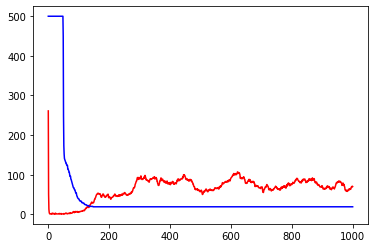

In [23]:
from numpy import *
import math
import matplotlib.pyplot as plt

iterations = linspace(0, ITERATIONS, ITERATIONS)

plt.plot(iterations, preys_count_history, 'r') # plotting t, a separately 
plt.plot(iterations, predators_count_history, 'b') # plotting t, b separately 
plt.show()